# PyTorch CNN filter visualization

We want to visualize our cnn-filters of a trained model.
* Filters
* Feature Maps

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# check if cuda is usable
if torch.cuda.is_available():
  device = 'cuda' 
else:
  device = 'cpu' 

print(f"Using device: {device}")

Using device: cpu


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.report import show_torch_image

In [3]:
!mkdir -p ./out/cnn_visualization

## Load ResNet-50
In this example we will use a pretrained ResNet-50 model.

In [4]:
model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# get model children
model_children = list(model.children())

conv_layers = []
conv_weights = []

# get all conv-layers with their weights
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        conv_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    conv_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total conv layers: {len(conv_layers)}")

for weight, conv in zip(conv_weights, conv_layers):
    print(f"Conv-Layer: {conv}, shape: {weight.shape}")

Total conv layers: 49
Conv-Layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), shape: torch.Size([64, 3, 7, 7])
Conv-Layer: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False), shape: torch.Size([64, 64, 1, 1])
Conv-Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), shape: torch.Size([64, 64, 3, 3])
Conv-Layer: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False), shape: torch.Size([256, 64, 1, 1])
Conv-Layer: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False), shape: torch.Size([64, 256, 1, 1])
Conv-Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), shape: torch.Size([64, 64, 3, 3])
Conv-Layer: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False), shape: torch.Size([256, 64, 1, 1])
Conv-Layer: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False), shape: torch.Size([64, 256, 1, 1])
Conv-Layer: Conv2d(64, 64, kernel_size=(3, 3), strid

## Visualize CNN filters

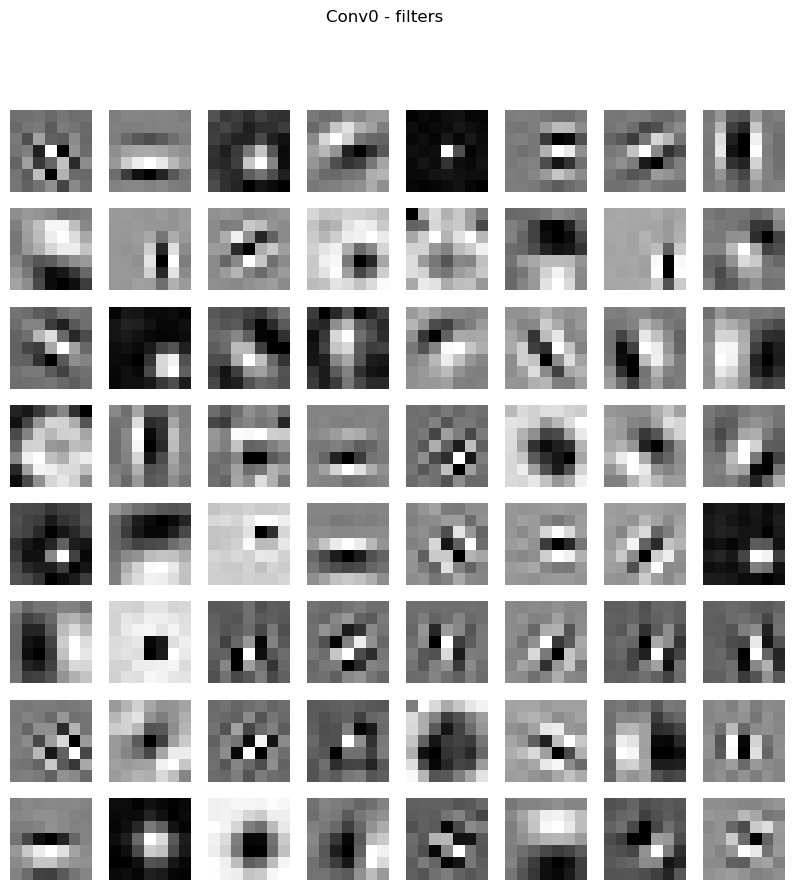

In [6]:
from lib.imageutil import visualize_image_grid

filters = []
for filter in conv_weights[0]:
    filters.append(filter[0, :, :].detach())

visualize_image_grid(filters, 'Conv0 - filters', save_to_file='./out/cnn_visualization/filter.png')

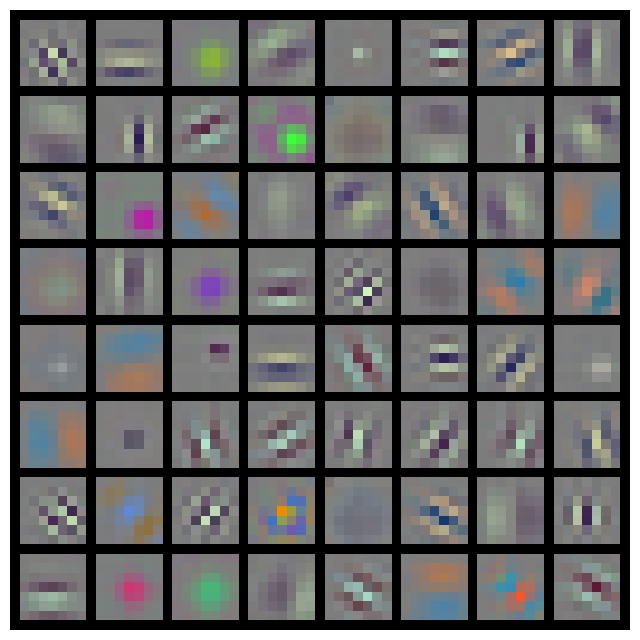

In [7]:
from lib.report import visualize_torch_tensor

visualize_torch_tensor(conv_weights[0])

## Visualize feature maps by using an example image

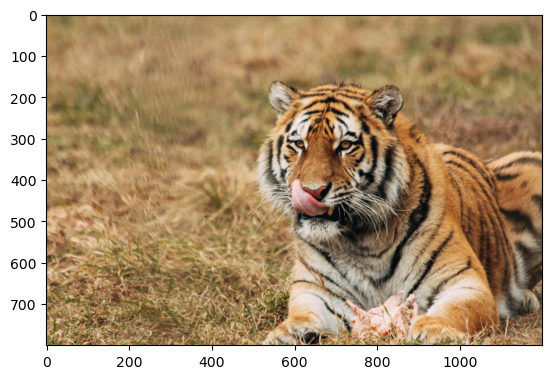

torch.Size([3, 512, 768])
torch.Size([1, 3, 512, 768])


In [8]:
img = cv2.imread(f"../images/tiger.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 768)),
    transforms.ToTensor(),
])

img = np.array(img)
img = transform(img)
print(img.size())

# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

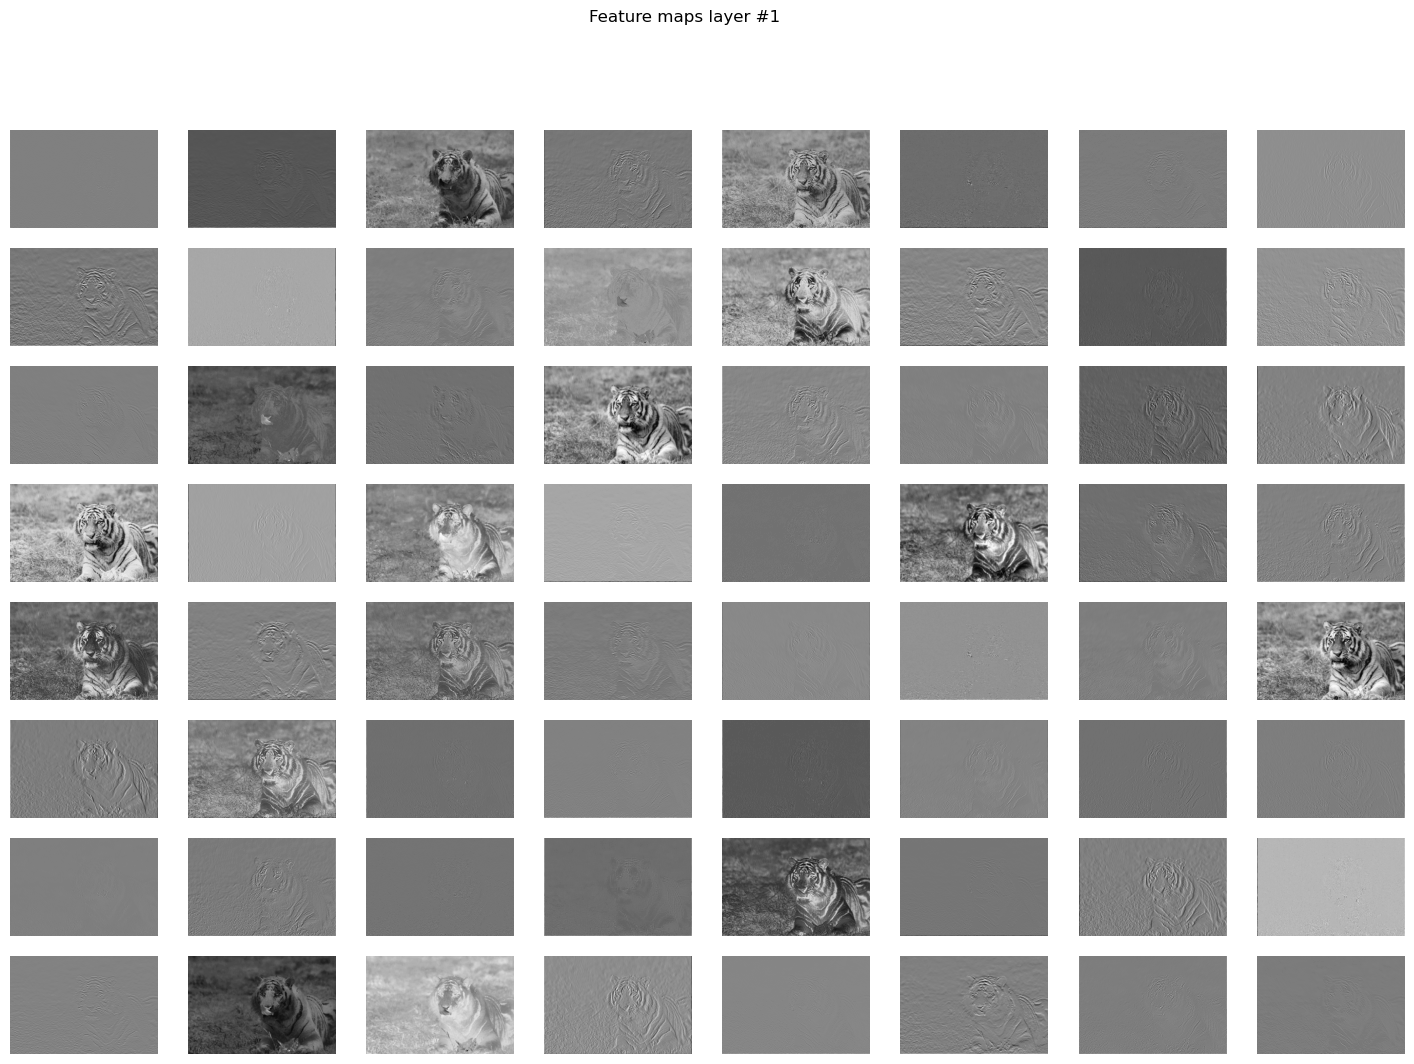

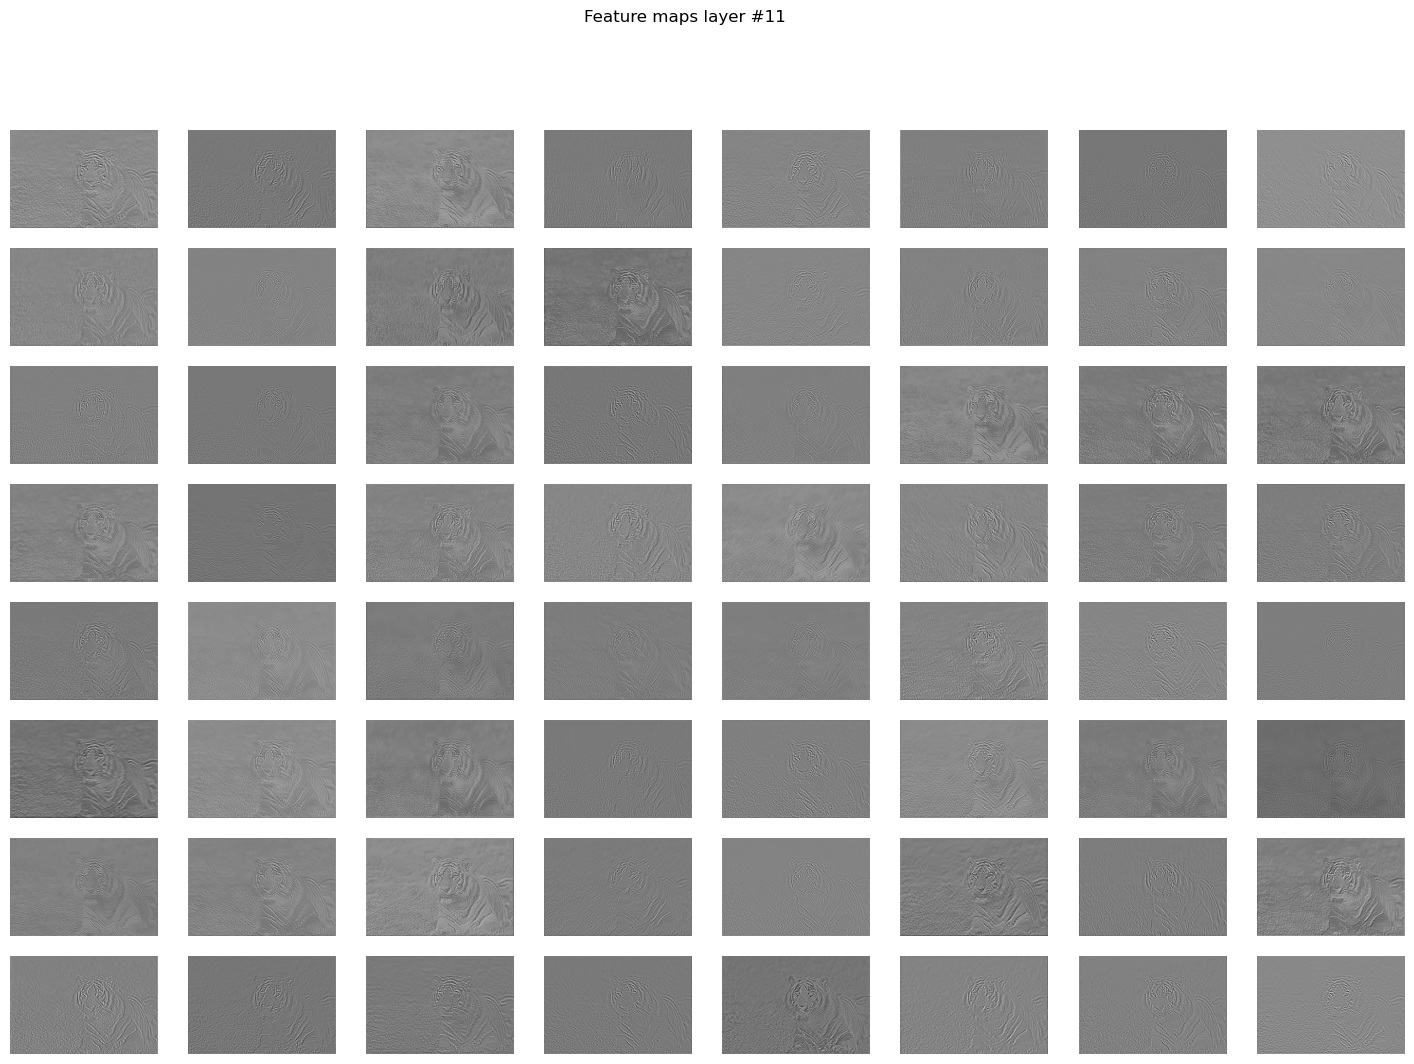

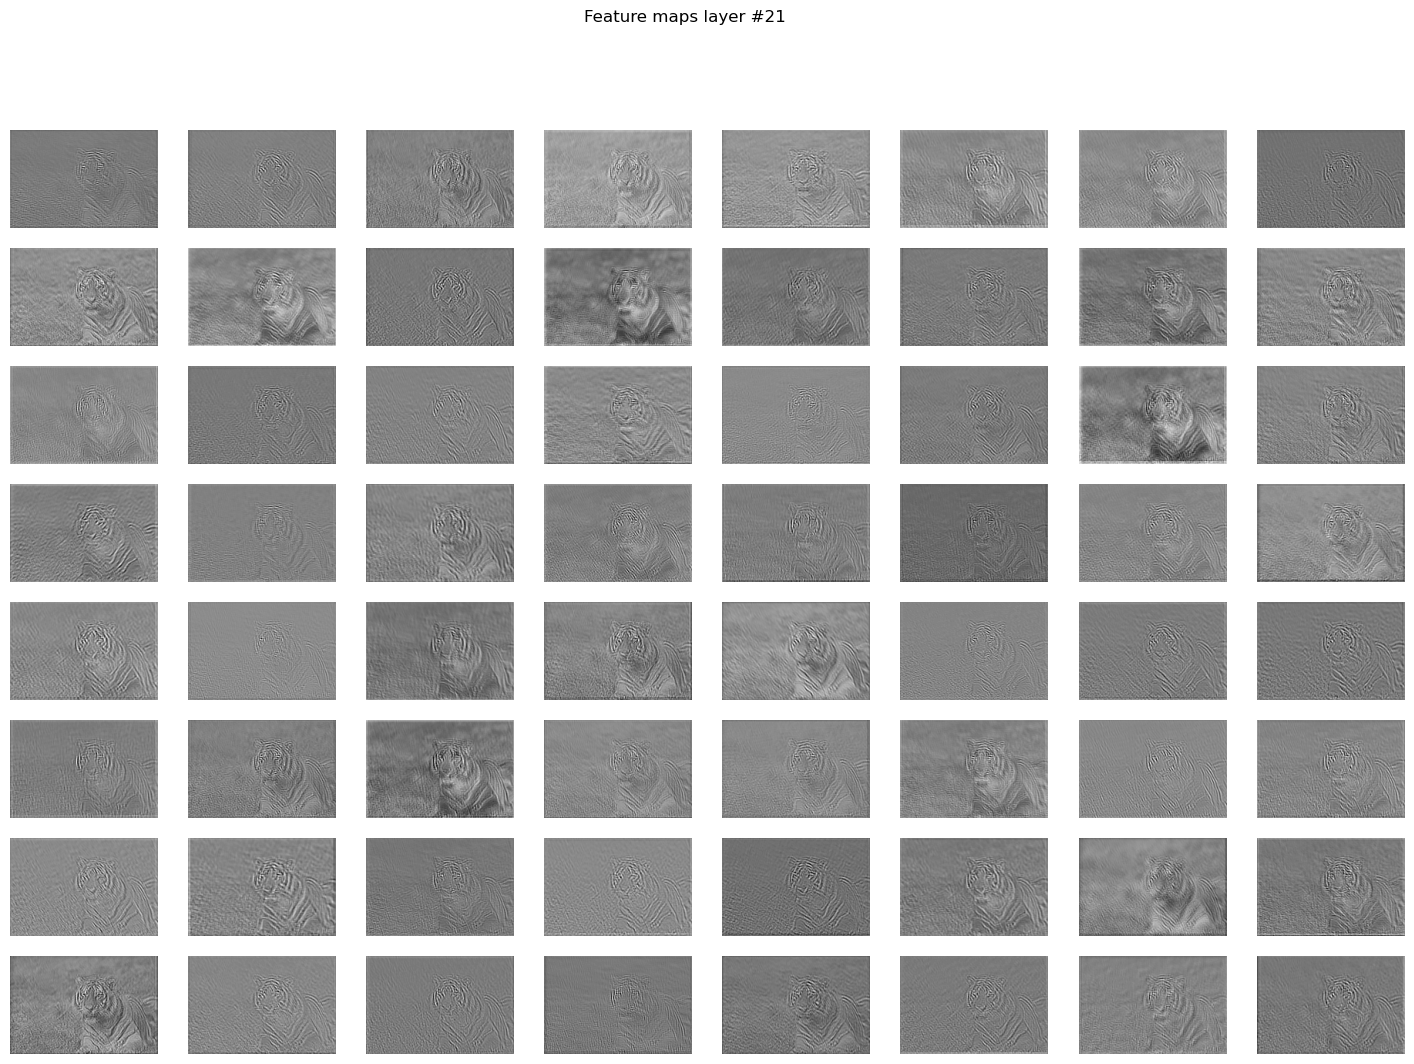

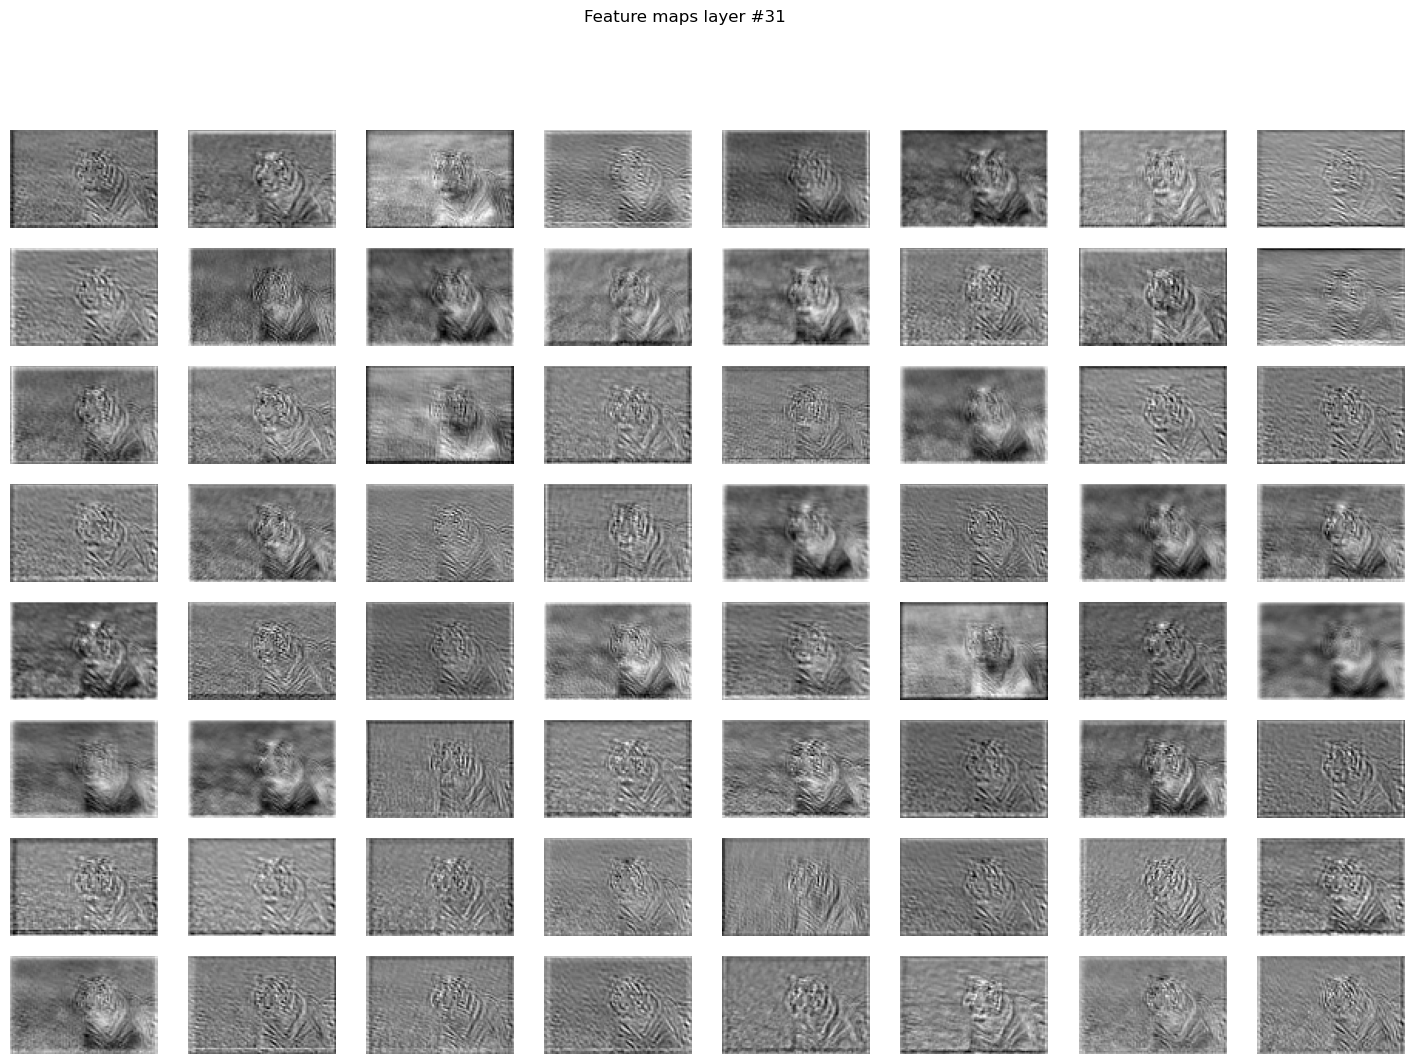

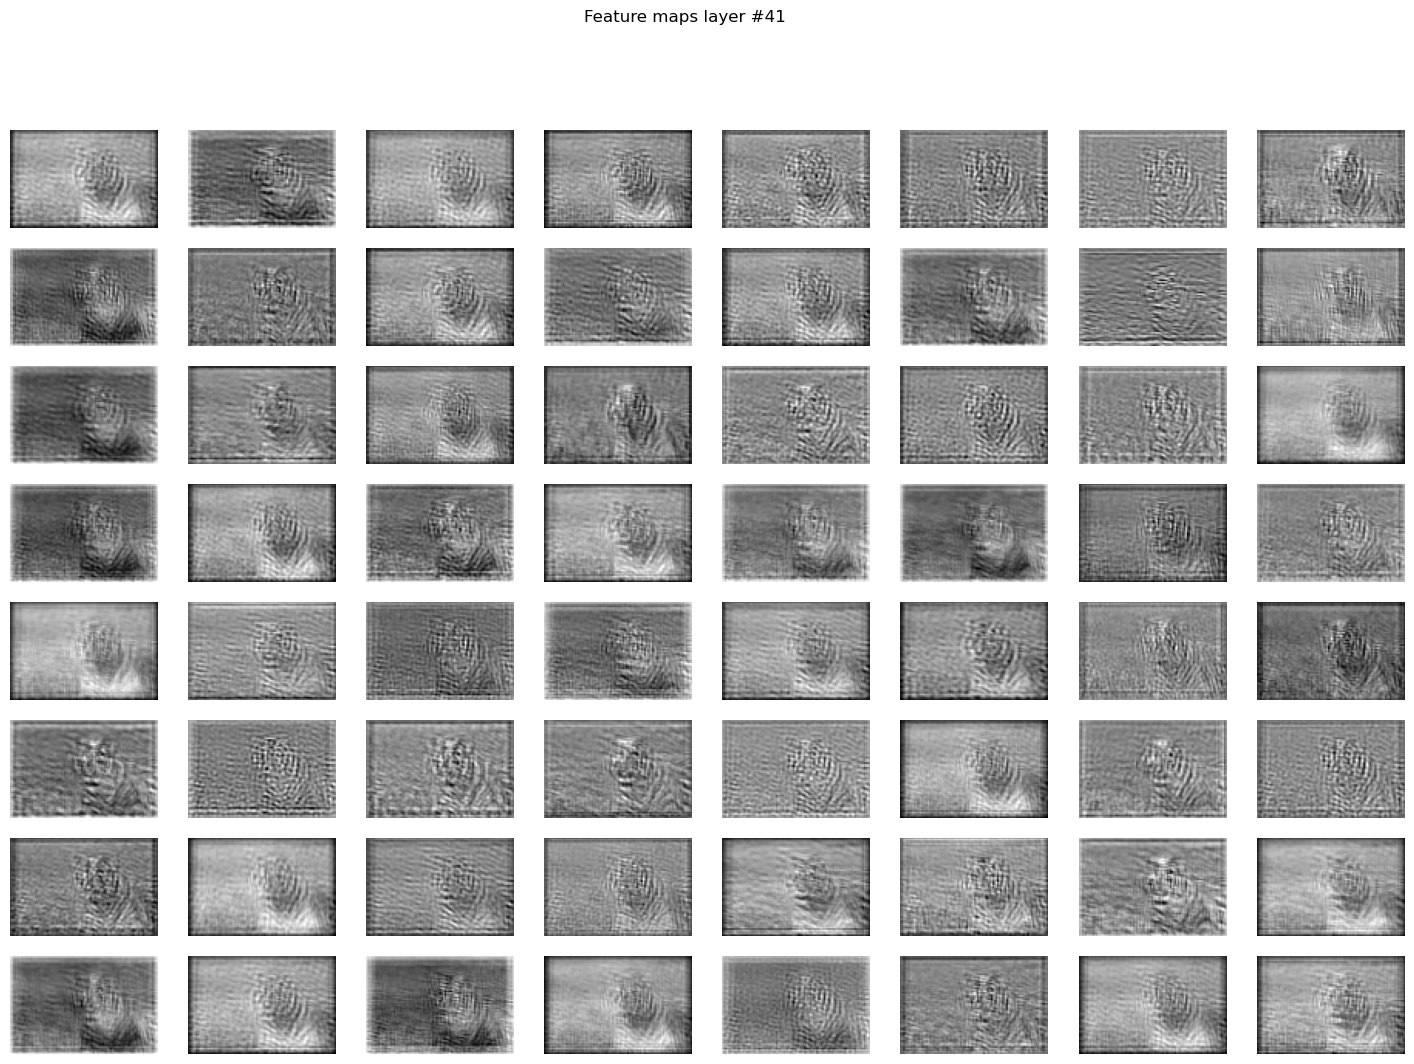

In [9]:
# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # send result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
outputs = results

# visualize 64 features from each layer 
for num_layer in range(len(outputs)):
    layer_visualization = outputs[num_layer][0, :, :, :].data

    # we show only a few of the feature maps as examples
    title = None
    if num_layer % 10 == 0:
        title = f'Feature maps layer #{num_layer+1}'
    
    visualize_image_grid(layer_visualization[:64], title, size=(18, 12),save_to_file=f'./out/cnn_visualization/layer_{num_layer}.png')

## Activation Maximization
We can use this implementation: [PytorchRevelio](https://github.com/farhad-dalirani/PytorchRevelio)

In [10]:
from lib.PytorchRevelio import PytorchRevelio
from lib.utilities_PytorchRevelio import imagenet_labels
from PIL import Image

In [11]:
print(model._modules)

OrderedDict([('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)), ('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), ('relu', ReLU(inplace=True)), ('maxpool', MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)), ('layer1', Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [ ]:
# network transformer for input image
network_input_shape = (224, 224, 3)

transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# for different convolutional filter and neuron in fully connected layer
# show representation
first_layer_name = 'conv1'
last_layer_name = 'layer1.0.conv1' #'fc'

for layer_name in model.named_modules():

    layer_name = layer_name[0]

    # select convolutional and fully connected layers for visualization
    layer = PytorchRevelio.return_module_by_name(network=model, module_name=layer_name)
    if isinstance(layer, nn.Conv2d):
        filter_neuron_num = layer.out_channels
        layer_type = 'Conv2d'
        num_iter = 300
        lr = 0.09
        start_sigma_color = 25
        end_sigma_color = 110
        start_sigma_space = 25
        end_sigma_space = 110
        kernel_size = 3
    elif isinstance(layer, nn.Linear):
        filter_neuron_num = layer.out_features
        layer_type = 'Linear'
        num_iter = 300
        lr = 0.09
        start_sigma_color = 25
        end_sigma_color = 110
        start_sigma_space = 25
        end_sigma_space = 110
        kernel_size = 3
    else:
        continue

    # from each layer select 8 filter our neurons
    filters_neuron_indexs = np.random.choice([i for i in range(filter_neuron_num)], size=8)

    # for each selected filter or neuron, calculate representation
    plt.figure()
    for i, filter_neuron_index in enumerate(filters_neuron_indexs):
        img = PytorchRevelio.activation_maximization_with_bilateral_blurring(
            network=model,
            img_transformer=transformer,
            in_img_size=network_input_shape,
            first_layer_name=first_layer_name,
            layer_name=layer_name,
            filter_or_neuron_index=filter_neuron_index,
            num_iter=num_iter,
            start_sigma_color=start_sigma_color,
            end_sigma_color=end_sigma_color,
            start_sigma_space=start_sigma_space,
            end_sigma_space=end_sigma_space,
            kernel_size=kernel_size,
            lr=lr,
            device=device)

        # to cpu and normalize for illustration purpose
        img = PytorchRevelio.tensor_outputs_to_image(img)

        ax = plt.subplot(2, 4, i+1)
        plt.imshow(img)
        if layer_name != last_layer_name:
            ax.set_title("{}".format(filter_neuron_index))
        else:
            ax.set_title("{}, {}".format(filter_neuron_index, imagenet_labels(class_number=filter_neuron_index)))

        plt.suptitle('Layer Name: {}, Type: {}'.format(layer_name, layer_type))
        ax.axis('off')
        print('Processing of layer {}, filter/neuron {} is done.'.format(layer_name, filter_neuron_index))

plt.show()

/home/user/mambaforge/lib/python3.9/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Processing of layer conv1, filter/neuron 41 is done.
Processing of layer conv1, filter/neuron 49 is done.
Processing of layer conv1, filter/neuron 24 is done.
Processing of layer conv1, filter/neuron 50 is done.
Processing of layer conv1, filter/neuron 8 is done.
Processing of layer conv1, filter/neuron 17 is done.
Processing of layer conv1, filter/neuron 10 is done.
Processing of layer conv1, filter/neuron 63 is done.
Processing of layer layer1.0.conv1, filter/neuron 15 is done.
Processing of layer layer1.0.conv1, filter/neuron 48 is done.
Processing of layer layer1.0.conv1, filter/neuron 42 is done.
Processing of layer layer1.0.conv1, filter/neuron 57 is done.
Processing of layer layer1.0.conv1, filter/neuron 19 is done.
Processing of layer layer1.0.conv1, filter/neuron 9 is done.
Processing of layer layer1.0.conv1, filter/neuron 27 is done.
Processing of layer layer1.0.conv1, filter/neuron 33 is done.
Processing of layer layer1.0.conv2, filter/neuron 46 is done.
Processing of layer 

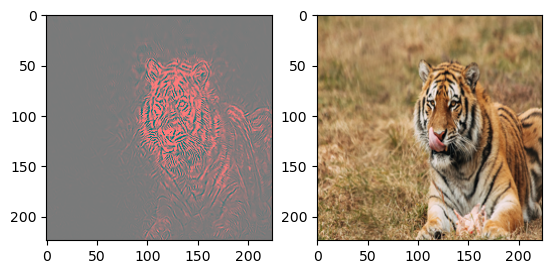

In [13]:
#for key, value in model.named_modules():
#        print('+' * 10)
#        print(key)
#        print('-' * 10)
#        print(value)

# transform for input image
img_transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
network_input_shape = (224, 224, 3)

first_layer_name = 'conv1'
last_layer_name = 'fc'

input_images = [("../images/tiger.jpg", 292)]


for input_image_name, class_number in input_images:

    # read input image
    input_image = Image.open(input_image_name).convert('RGB')

    gradients = PytorchRevelio.saliency_map_guided(network=model,
                                                    input_image=input_image,
                                                    class_number=class_number,
                                                    img_transformer=img_transformer,
                                                    first_layer_name=first_layer_name,
                                                    device=device)

    gradients = PytorchRevelio.tensor_outputs_to_image(gradients)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(gradients)
    plt.subplot(1, 2, 2)
    plt.imshow(input_image.resize(size=(224, 224)))

plt.show()

## Saliency map

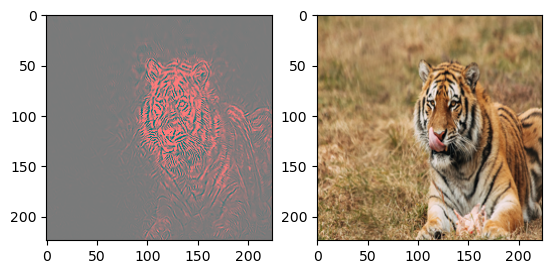

In [14]:
for input_image_name, class_number in input_images:

    # read input image
    input_image = Image.open(input_image_name).convert('RGB')

    gradients = PytorchRevelio.saliency_map_guided(network=model,
                                                    input_image=input_image,
                                                    class_number=class_number,
                                                    img_transformer=img_transformer,
                                                    first_layer_name=first_layer_name,
                                                    device=device)

    gradients = PytorchRevelio.tensor_outputs_to_image(gradients)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(gradients)
    plt.subplot(1, 2, 2)
    plt.imshow(input_image.resize(size=(224, 224)))

plt.show()

In [10]:
print(model.layer1[0].conv1)

Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [11]:
from lib.activation_maximization_visualized import ActivationMaxVisualization

cnn_layer = 16
cnn_filter = 28
epochs = 51

out_layer = ActivationMaxVisualization(model, epochs, model.layer1[0].conv1)
out_layer.vis_cnn_layer('./out/cnn_visualization')

AttributeError: 'ActivationMaxVisualization' object has no attribute 'read'

## Grad CAM in PyTorch
https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82